In [2]:
import pandas as pd
import numpy as np
import helper_functions as hf
import pickle
import matplotlib.pyplot as plt
import importlib
import math
import copy
import re
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import random
importlib.reload(hf)
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

from collections import Counter


In [13]:
data_dir = "C:/Users/ctata/Documents/Lab/quality_vectors_git/data/"
fig_dir = "C:/Users/ctata/Documents/Lab/quality_vectors_git/figures/"

otu = pd.read_csv(data_dir + "IBD_huttenhower/seqtab_final.txt", sep = " ") #beware seqtab_final where some of the index values don't get read in as characters
print(otu.shape)
otu.index.values

mapping = pd.read_csv(data_dir + "IBD_huttenhower/mapping.txt", sep = "\t")
print(mapping.shape)
mapping.index.values
mapping.visit_study_disease_name[mapping.visit_study_disease_name == "crohn's disease"] = "CD"
mapping.visit_study_disease_name[mapping.visit_study_disease_name == "ulcerative colitis"] = "UC"
mapping.visit_study_disease_name[mapping.visit_study_disease_name.isna()] = "HC"


sample_names = mapping.index.values[[(i in otu.index.values) for i in mapping.index.values]]
print("sample names shape: " + str(len(sample_names)))
otu = otu.loc[sample_names, :]
mapping = mapping.loc[sample_names, :]
print(otu.shape)

(274, 5869)
(197, 58)
sample names shape: 100
(100, 5869)


In [5]:
sample_names = otu.index.values[np.sum(otu, axis = 1) < 100000]
otu = otu.loc[sample_names, :]
mapping = mapping.loc[sample_names, :]
print(mapping.shape)
Counter(mapping.visit_study_disease_name)

(49, 58)


Counter({'HC': 15, 'UC': 13, 'CD': 21})

In [3]:
EMBED = pd.read_csv(data_dir + "IBD_huttenhower/embed/embedded_.07_97id_100dim.txt", sep = "\t")
EMBED = EMBED.loc[mapping.index.values, :]
EMBED.shape

(100, 100)

In [8]:
def getDiagnosisInfo(otu_train, otu_test, map_train, map_test, pos_class, neg_class):
    map_train = map_train.loc[[i in neg_class or i in pos_class for i in map_train.visit_study_disease_name], :]
    map_test = map_test.loc[[i in neg_class or i in pos_class for i in map_test.visit_study_disease_name], :]
    otu_train = otu_train.loc[map_train.index.values, :]
    otu_test = otu_test.loc[map_test.index.values, :]
    y_train = [i in pos_class for i in map_train.visit_study_disease_name.values]
    y_test = [i in pos_class for i in map_test.visit_study_disease_name.values]
    return(otu_train, otu_test, y_train, y_test)

def trainHyperParameters(X_train, y_train):
 #Gets passed a training set, and a 1,0 ground truth vector
    aucs = []
    precisions = []
    f1s = []
    
    #depths = [2, 3, 5, 7]
    #n_estimators = [50, 70, 90, 110, 130]
    #weights = [1, 3, 5, 10, 15]
    
    #depths = [2, 3, 5, 10]
    #n_estimators = [50, 65, 80, 95, 110, 125, 140, 155]
    
    depths = [2, 3]
    n_estimators = [50, 70]
    weights = [1, 3]
    
    df = np.zeros((len(depths) * len(n_estimators) * len(weights), 6))
    i = 0
    for max_depth in depths:
        for n_est in n_estimators:
            for weight in weights:
                #print(max_depth, n_est, weight, end = "\t")
                auc_crossVal, auc_prec_crossVal, f1_crossVal, _ = hf.crossValPrediction(X_train, y_train,
                                                                                        max_depth = max_depth,
                                                                                        n_estimators = n_est,
                                                                                        weight = weight ,
                                                                                        folds = 3)
                df[i, :] = [np.mean(auc_crossVal), np.mean(auc_prec_crossVal), np.mean(f1_crossVal), 
                                   max_depth, n_est, weight]
                i += 1
   
    return(df)

In [9]:
def getParamDfs(X_train, y_train):
    global EMBED
    asin_params = trainHyperParameters(hf.asinh(X_train), y_train)

    embed_params = trainHyperParameters(EMBED.loc[X_train.index.values, :], y_train)
    
    pca = PCA(n_components= np.min([EMBED.shape[1], X_train.shape[0]]))
    pca.fit(hf.asinh(X_train))
    otu_pca = pd.DataFrame(pca.transform(hf.asinh(X_train)))
    pca_params = trainHyperParameters(otu_pca, y_train)
    
    return(asin_params, embed_params, pca_params)

def getBestParams(params):
    #f1 metric
    tmp = params[np.argmax(params[:, 2]), :]
    print(tmp)
    return([int(i) for i in tmp[3:6]])

In [14]:
importlib.reload(hf)

def drawFigures(X_train, X_test, y_train, y_test, asin_params, embed_params, pca_params):
    global EMBED
    plot = False
    f = plt.figure(figsize=(15,5))
    _, roc_auc_asin, _, _, _, pr_auc_asin, _, _, _ = hf.predictIBD(X_train = hf.asinh(X_train),
                                                                                X_test = hf.asinh(X_test),
                                                                                y_train = y_train,
                                                                                y_test = y_test,
                                                                                max_depth = asin_params[0],
                                                                                n_estimators = asin_params[1],
                                                                                weight = asin_params[2],
                                                                                plot = plot, plot_pr = plot)
    print("Asinh")
    #print(otu_use.shape)
    #print(np.mean(auc_crossVal))
    #print(np.mean(auc_prec_crossVal))
    f.savefig(fig_dir + "curves_halfvarson_asin_tmp.pdf")


    
    embedded = EMBED.loc[X_train.index.values, :]
    embedded_test = EMBED.loc[X_test.index.values, :]
    f = plt.figure(figsize=(15,5))
    _, roc_auc_embed, _, _, _, pr_auc_embed, _, _, _ = hf.predictIBD(X_train = embedded,
                                                                     X_test = embedded_test,
                                                                     y_train = y_train,
                                                                     y_test = y_test,
                                                                     max_depth = embed_params[0],
                                                                     n_estimators = embed_params[1],
                                                                     weight = embed_params[2],
                                                                     plot = plot, plot_pr = plot)
    print("Embed")
    #print(embedded.shape)
    #print(np.mean(auc_crossVal))
    #print(np.mean(auc_prec_crossVal))
    f.savefig(fig_dir + "curves_halfvarson_embed_tmp.pdf")



    f = plt.figure(figsize=(15,5))
    from sklearn.decomposition import PCA
    pca = PCA(n_components= np.min([EMBED.shape[1], X_train.shape[0]]))
    pca.fit(hf.asinh(X_train))
    otu_pca = pd.DataFrame(pca.transform(hf.asinh(X_train)))
    otu_pca_test = pd.DataFrame(pca.transform(hf.asinh(X_test)))
    _, roc_auc_pca, _, _, _, pr_auc_pca, _, _, _ = hf.predictIBD(X_train = otu_pca,
                                                               X_test = otu_pca_test, 
                                                               y_train = y_train,
                                                               y_test = y_test,
                                                               max_depth = pca_params[0],
                                                               n_estimators = pca_params[1],
                                                               weight = pca_params[2],
                                                                plot = plot, plot_pr = plot)
    print("PCA")
    #print(otu_pca.shape)
    #print(np.mean(auc_crossVal))
    #print(np.mean(auc_prec_crossVal))
    #f.savefig(fig_dir + "curves_halfvarson_pca_tmp.pdf")
    return(roc_auc_asin, pr_auc_asin, roc_auc_embed, pr_auc_embed, roc_auc_pca, pr_auc_pca)

In [7]:
otu.shape
mapping.shape

(100, 58)

In [17]:
EMBED.loc[otu_train.index.values, :]

,property_100_1,property_100_2,property_100_3,property_100_4,property_100_5,property_100_6,property_100_7,property_100_8,property_100_9,property_100_10,...,property_100_91,property_100_92,property_100_93,property_100_94,property_100_95,property_100_96,property_100_97,property_100_98,property_100_99,property_100_100
MSM5LLGV_P,362.511648,561.630915,48.029881,325.405080,-383.830333,226.289596,-404.205078,6.544978,29.377305,-585.378975,...,-658.194295,-623.863337,-53.986993,-131.775182,-148.854654,-105.400109,-351.925314,-59.916932,326.085659,-328.372344
219634,288.904883,462.854203,38.678724,194.599103,-363.988038,181.410048,-136.909236,86.694129,60.893406,-372.687284,...,-353.697034,-391.563227,-0.687814,-144.165810,-6.699897,-20.223843,-329.251463,-118.390930,56.617066,-228.033112
219655,285.656953,471.909251,16.601352,206.023808,-396.555497,212.246604,-193.348629,86.518535,82.433737,-420.074344,...,-371.893491,-466.900365,-22.427730,-160.239635,-24.581069,-39.866927,-323.183048,-72.357558,73.163050,-252.330756
HSM5MD5H_P,260.327621,471.040352,35.238136,190.579279,-303.884489,112.257944,-219.322093,69.857215,90.004475,-293.251656,...,-314.396834,-357.285335,-88.206750,-20.533448,-41.687768,-3.980315,-278.492330,-69.535239,89.711340,-202.453497
219676,205.546219,336.036590,15.493955,86.181480,-207.229011,70.016212,15.498995,-26.827613,51.943540,-190.375645,...,-175.581162,-109.951865,71.624716,-59.992133,12.383408,22.800109,-201.355354,-173.041129,14.597449,-238.111062
215084,196.337038,320.362924,2.159595,129.288762,-210.978279,107.439728,-100.287777,28.959078,45.993456,-195.022746,...,-232.677132,-229.754804,-34.313224,-48.727662,-48.218183,-8.750000,-174.038390,-24.238340,97.973022,-196.209787
MSM5FZA2_P,518.897553,613.167733,-100.243368,443.547529,-433.353204,365.579237,-357.846342,19.480987,33.122294,-626.957716,...,-733.154949,-726.779589,45.555795,-105.698702,-165.329123,-63.963253,-423.677627,-195.483861,393.013389,-544.605313
ESM5MEE2_P,246.117380,414.796834,42.445712,198.463845,-323.778491,195.897382,-207.011589,111.600865,113.755968,-362.451659,...,-319.498017,-388.856555,-63.796350,-39.742016,-65.623498,-31.449731,-267.828418,-30.316326,29.116639,-189.327537
219670,399.545179,560.743575,103.584092,337.642524,-437.257136,276.633396,-330.121707,141.214010,56.991107,-599.401421,...,-566.736719,-631.904490,11.980221,-226.494728,-65.856064,-52.677254,-392.754360,-139.305769,110.492349,-333.448507
219669,466.976995,639.622108,93.255213,375.175684,-494.756763,305.039339,-352.295593,151.112746,63.350409,-694.648625,...,-692.972249,-749.860284,51.305628,-276.077616,-42.910775,-43.835720,-477.678736,-193.303831,141.213393,-409.734428


In [24]:
train_sizes = [10, 30, 50, 70]
np.random.seed(83)
train_samples = np.random.choice(mapping.index.values, train_sizes[i])
test_samples = mapping.index.values[[(not i in train_samples) for i in mapping.index.values]   ]         
map_train = mapping.loc[train_samples, :]
map_test = mapping.loc[test_samples, :]
otu_train = otu.loc[map_train.index.values, :]
otu_test = otu.loc[map_test.index.values, :]
otu_test.shape[0] / (otu_train.shape[0] + otu_test.shape[0])


y_train = [i in ['CD', 'UC'] for i in map_train.visit_study_disease_name.values]
y_test = [i in ['HC'] for i in map_test.visit_study_disease_name.values]

print(np.sum(y_test))
print(np.sum([i == 0 for i in y_test]))

12
50


In [29]:
y_test

[True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

0
(86, 5869)
86
[ 1.  1.  1.  2. 50.  1.]
[ 1.  1.  1.  2. 50.  1.]
[ 1.  1.  1.  2. 70.  1.]
Asinh
Embed
PCA
Train size: 15
ROC asin: 0.31878787878787884
PR asin: 0.09881307276075096
ROC embed: 0.22909090909090912
PR embed: 0.08660647995376776
ROC pca: 0.2163636363636363
PR pca: 0.08522993403487855
1
(73, 5869)
73
[ 1.          1.          0.93333333  2.         70.          1.        ]
[ 1.          1.          0.93333333  2.         50.          3.        ]
[ 1.  1.  1.  3. 50.  3.]
Asinh
Embed
PCA
Train size: 30
ROC asin: 0.3441558441558441
PR asin: 0.08318700046569277
ROC embed: 0.2532467532467533
PR embed: 0.07023652817770465
ROC pca: 0.09090909090909091
PR pca: 0.05964585784229767
2
(62, 5869)
62
[ 1.  1.  1.  3. 50.  1.]
[ 1.          1.          0.96296296  2.         70.          1.        ]
[ 1.  1.  1.  3. 50.  3.]
Asinh
Embed
PCA
Train size: 50
ROC asin: 0.047619047619047616
PR asin: 0.05971923158549768
ROC embed: 0.12500000000000003
PR embed: 0.0628675391110506
ROC pca: 0

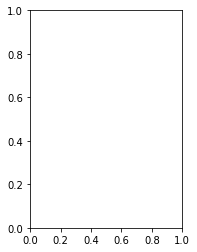

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

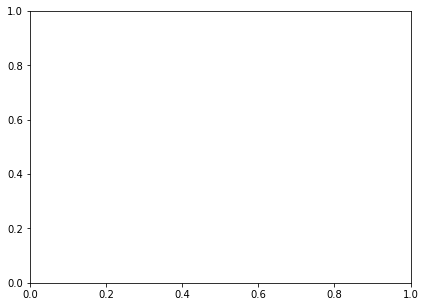

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

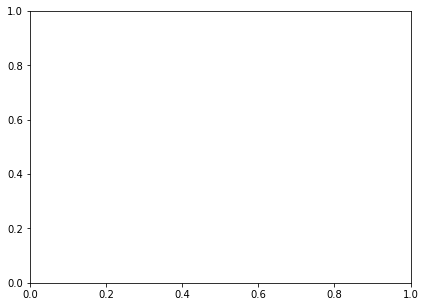

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

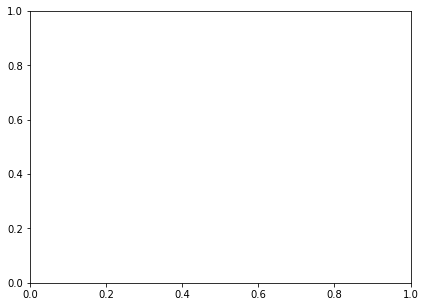

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

In [31]:
train_sizes = [15, 30, 50, 70]
n = len(train_sizes)
df = pd.DataFrame({'train_size' : np.zeros(n), 'roc_asin': np.zeros(n), 'pr_asin':np.zeros(n),
                                               'roc_embed': np.zeros(n), 'pr_embed':np.zeros(n),
                                                'roc_pca': np.zeros(n), 'pr_pca':np.zeros(n)})
i = 0

for i in range(n):
    print(i)
    np.random.seed(83)
    train_samples = np.random.choice(mapping.index.values, train_sizes[i])
    test_samples = mapping.index.values[[(not i in train_samples) for i in mapping.index.values]   ]         
    map_train = mapping.loc[train_samples, :]
    map_test = mapping.loc[test_samples, :]
    otu_train = otu.loc[map_train.index.values, :]
    otu_test = otu.loc[map_test.index.values, :]
    otu_test.shape[0] / (otu_train.shape[0] + otu_test.shape[0])


    y_train = [i in ['CD', 'UC'] for i in map_train.visit_study_disease_name.values]
    y_test = [i in ['HC'] for i in map_test.visit_study_disease_name.values]

    print(otu_test.shape)
    print(len(y_test))
    asin_params , embed_params, pca_params = getParamDfs(otu_train, y_train)

    asin_params_best = getBestParams(asin_params)
    embed_params_best = getBestParams(embed_params)
    pca_params_best = getBestParams(pca_params)
    
    roc_auc_asin, pr_auc_asin, roc_auc_embed, pr_auc_embed, roc_auc_pca, pr_auc_pca = drawFigures(otu_train, otu_test, y_train, y_test,
                                                                                    asin_params_best, embed_params_best, pca_params_best)
    
    
    df.roc_asin[i] = roc_auc_asin
    df.pr_asin[i] = pr_auc_asin
    df.roc_embed[i] = roc_auc_embed
    df.pr_embed[i] = pr_auc_embed
    df.roc_pca[i] = roc_auc_pca
    df.pr_pca[i] = pr_auc_pca
    
    print("Train size: " + str(otu_train.shape[0]))
    print("ROC asin: " + str(roc_auc_asin))
    print("PR asin: " + str(pr_auc_asin))
    print("ROC embed: " + str(roc_auc_embed))
    print("PR embed: " + str(pr_auc_embed))
    print("ROC pca: " + str(roc_auc_pca))
    print("PR pca: " + str(pr_auc_pca))